# Random Forest Classifier for Classification Task

This notebook applies a **Random Forest Classifier** to perform a binary classification task. The objective is to predict the `NLOS` class using extracted features. The key steps include:

- Loading and preprocessing the data
- Training a Random Forest Classifier
- Performing hyperparameter tuning using `RandomizedSearchCV`
- Evaluating the model's performance using accuracy, precision, and recall

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint

from sklearn.tree import export_graphviz
import graphviz

dataset = pd.read_csv('../data/processed/aggregated_dataset.csv')

dataset = dataset.iloc[:, :15]

dataset

,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,CIR0,CIR1,CIR2,CIR3,CIR4
0,0.0,3.90,745.0,18712.0,10250.0,11576.0,64.0,11855.0,967.0,611.0,129.0,312.0,331.0,141.0,160.0
1,0.0,0.66,749.0,11239.0,6313.0,4712.0,64.0,18968.0,1133.0,447.0,117.0,163.0,199.0,136.0,142.0
2,1.0,7.86,746.0,4355.0,5240.0,3478.0,60.0,14699.0,894.0,723.0,433.0,240.0,233.0,81.0,143.0
3,1.0,3.48,750.0,8502.0,8416.0,5890.0,76.0,8748.0,1127.0,1024.0,466.0,247.0,407.0,225.0,279.0
4,0.0,1.19,746.0,17845.0,18095.0,12058.0,68.0,11380.0,1744.0,276.0,259.0,239.0,57.0,19.0,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40669,0.0,2.43,745.0,12960.0,17703.0,14948.0,96.0,9987.0,2379.0,276.0,202.0,224.0,51.0,300.0,284.0
40670,0.0,1.39,745.0,2235.0,15089.0,8796.0,76.0,12559.0,1810.0,281.0,190.0,153.0,199.0,85.0,167.0
40671,1.0,5.48,747.0,7115.0,6262.0,4584.0,72.0,1435.0,1092.0,1024.0,504.0,363.0,188.0,150.0,260.0
40672,1.0,3.40,745.0,6662.0,7683.0,5600.0,72.0,1491.0,1077.0,1024.0,337.0,396.0,243.0,245.0,105.0


## Data Loading and Preprocessing

The dataset is loaded using `pandas`. Features are separated from the target column `NLOS`. The dataset is also reduced to only relevant columns for model training.

In [2]:
X = dataset.drop('NLOS', axis=1)
y = dataset['NLOS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Data Splitting

The data is split into training and test sets using `train_test_split`. This ensures that the model is evaluated on unseen data for an unbiased performance estimate.

In [3]:
rf = RandomForestClassifier(random_state=42)

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = {'n_estimators': [200], 'max_depth': [25]},
                                 n_iter = 1,
                                 cv = 4,
                                 random_state=42,
                                 n_jobs=-1,
                                 scoring='neg_mean_squared_error',
                                 verbose=2)

rand_search.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'max_depth': [25],
                                        'n_estimators': [200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [4]:
y_pred = rand_search.predict(X_test)

## Model Training and Hyperparameter Tuning

A `RandomForestClassifier` is initialized and hyperparameter tuning is performed using `RandomizedSearchCV`. Randomized search is a faster and more efficient method for finding the best hyperparameters. The key hyperparameters optimized are:

- **n_estimators**: Number of trees in the forest
- **max_depth**: Maximum depth of the trees

In [5]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Classification Accuracy: ', accuracy)
print('Precision (Positive Predictive Value): ', precision)
print('Recall (Sensitivity / True Positive Rate): ', recall)

Classification Accuracy:  0.9064535955746773
Precision (Positive Predictive Value):  0.9181392931392931
Recall (Sensitivity / True Positive Rate):  0.8879115355616989


In [6]:
best_rf = rand_search.best_estimator_

print('Best hyperparameters: ', rand_search.best_params_)

Best hyperparameters:  {'n_estimators': 200, 'max_depth': 25}


## Model Evaluation

The classifier's predictions are evaluated using several metrics:

- **Accuracy**: The ratio of correct predictions to total predictions.
- **Precision**: The proportion of positive predictions that are actually correct.
- **Recall**: The proportion of actual positives that are correctly identified.

These metrics provide a comprehensive assessment of the model's classification performance.

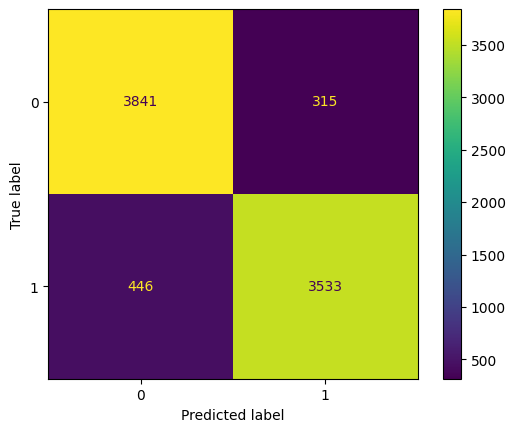

In [7]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: >

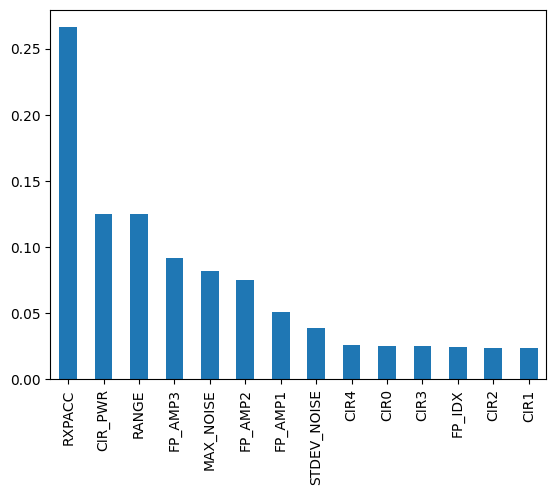

In [8]:
feature_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_importance.plot.bar()